In [0]:
# <Don't Run>

In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd 

from PIL import Image

from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.segmentation import mark_boundaries
  
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
# from dask.array.image import imread
# from dask import bag, threaded
# from dask.diagnostics import ProgressBar

from tqdm import tqdm
from itertools import chain
from glob import glob

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Let's check the list of objects

In [0]:
os.listdir('/content/drive/My Drive/Capstone/')

['train_color',
 'train_label',
 'EvaluationScriptsAndExamples',
 'test_video_list_and_name_mapping',
 'train_video_list',
 'test',
 'UNet Testing',
 'model.json',
 'model.h5',
 'Instance Segmentation',
 'CVPR_Ref_Airbus_Mask_RCNN_and_COCO_transfer_learning_V2.ipynb']

Let's assess the number of images and the size

In [0]:
def filecheck(dir):
  dir_size = 0
  filelist = os.listdir(dir)
  filelist.sort()
  print(dir)
  for i,name in enumerate(filelist):
    dir_size += os.path.getsize(os.path.join(dir,name))
  print("{:.4f} Gb of {} files".format(dir_size/1024/1024/1024,i))
  print("Showig Sample files")
  print("\n".join(filelist[300:306]) + "\n")
  
dirs = ['/content/drive/My Drive/Capstone/train_color/', '/content/drive/My Drive/Capstone/train_label/', '/content/drive/My Drive/Capstone/test/']
        
for d in dirs[0:3]:
  filecheck(d)
  

/content/drive/My Drive/Capstone/train_color/
2.0821 Gb of 999 files
Showig Sample files
170908_061523257_Camera_5.jpg
170908_061523257_Camera_6.jpg
170908_061523396_Camera_5.jpg
170908_061523396_Camera_6.jpg
170908_061523535_Camera_5.jpg
170908_061523535_Camera_6.jpg

/content/drive/My Drive/Capstone/train_label/
0.0251 Gb of 999 files
Showig Sample files
170908_061523257_Camera_5_instanceIds.png
170908_061523257_Camera_6_instanceIds.png
170908_061523396_Camera_5_instanceIds.png
170908_061523396_Camera_6_instanceIds.png
170908_061523535_Camera_5_instanceIds.png
170908_061523535_Camera_6_instanceIds.png

/content/drive/My Drive/Capstone/test/
1.0246 Gb of 499 files
Showig Sample files
5d498d98aad3ff03648a17280caf561e.jpg
5d637880a30e1981a805d5ec9e81df96.jpg
5d80002a07120ae07067dc402e55d3de.jpg
5d8746134904a462b5c5993be60e267e.jpg
5dc0afe0bbf30d66796453984076afc9.jpg
5dd6432f67a2bd2073a8481d287da44f.jpg



Let's take a look at Training set data

[33 33 33 ... 33 33 33]


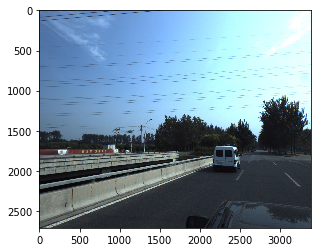

None

In [0]:
im = Image.open("/content/drive/My Drive/Capstone/train_color/170908_061523257_Camera_5.jpg")
tlabel = np.asarray(Image.open("/content/drive/My Drive/Capstone/train_label/170908_061523257_Camera_5_instanceIds.png"))//1000
print(tlabel[tlabel>0])
tlabel[tlabel!=0] = 255
plt.imshow(im)
display(plt.show())

The training images labels are encoded in a format mixing spatial and label/instance information:
  All the images are of the same size (width, height) 
  
  
1.   Pixel values indicate both the label and the instance.
2.   Each label could contain multiple object instances.
3.   int(PixelValue / 1000) is the label (class of object)
4.   PixelValue % 1000 is the instance id
5.   For example, a pixel value of 33000 means it belongs to label      33 (a car), is instance #0, while the pixel value of 33001          means it also belongs to class 33 (a car) , and is instance        #1. These represent two different cars in an image. 









Lets check the kind of labels we have got and their overall count

In [0]:
tlabel = np.asarray(Image.open("/content/drive/My Drive/Capstone/train_label/170908_061523257_Camera_5_instanceIds.png"))
unique, counts = np.unique(tlabel, return_counts=True)
print(unique)
print(counts)

[  255 33000 33001 33002 33003 33004 39000 40000 65535]
[9065795   99301    1422     669      76      53     178     349    2797]


Since Pixel label and Instances are filled for each pixel, There are multiple entries for the same instance, so we need to take unique entries

In [0]:
# cutting off everything after class 65, see note below
classdict = {0:'others', 1:'rover', 17:'sky', 33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 37:'rider', 38:'truck', 39:'bus', 40:'tricycle', 49:'road', 50:'siderwalk', 65:'traffic_cone'}

tlabel = np.asarray(Image.open("/content/drive/My Drive/Capstone/train_label/170908_061523257_Camera_5_instanceIds.png"))

# Below unique function takes the unique values of label_instance combination

cls = np.unique(tlabel)//1000
print("Label Instances : ", cls)

# Below unique function takes the unique labels alone (instance id gets eliminated due to Int division)

unique, counts = np.unique(cls, return_counts=True)
d = dict(zip(unique, counts))
df = pd.DataFrame.from_dict(d, orient='index').transpose()
df.rename(columns=classdict, inplace=True)
df

Label Instances :  [ 0 33 33 33 33 33 39 40 65]


others  car  bus  tricycle  traffic_cone
0       1    5    1         1             1

Let's check Camera 6 and highlight labels' pixels

[ 0 33 33 33 33 33 33 33 33 39 40]


others  car  bus  tricycle
0       1    8    1         1

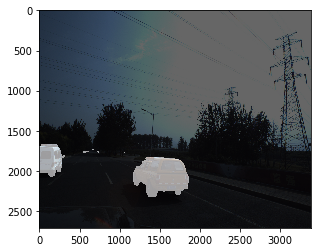

In [0]:
im = Image.open("/content/drive/My Drive/Capstone/train_color/170908_061523257_Camera_6.jpg")


tlabel1 = np.asarray(Image.open("/content/drive/My Drive/Capstone/train_label/170908_061523257_Camera_6_instanceIds.png"))//1000

# Highlighting label's pixels
tlabel1[tlabel1!= 0] = 255

plt.imshow(Image.blend(im, Image.fromarray(tlabel1).convert('RGB'), alpha=0.6))

# This unique takes the unique values of label_instance combination

tlabel = np.asarray(Image.open("/content/drive/My Drive/Capstone/train_label/170908_061523257_Camera_6_instanceIds.png"))
cls = np.unique(tlabel)//1000
print(cls)

# This unique takes the unique labels alone (instance id gets eliminated due to Int division)

unique, counts = np.unique(cls, return_counts=True)
d = dict(zip(unique, counts))
df = pd.DataFrame.from_dict(d, orient='index').transpose()
df.rename(columns=classdict, inplace=True)
df


Lets create Class dictionary from the Class List

In [0]:
class_str = """car, 33
motorbicycle, 34
bicycle, 35
person, 36
rider, 37
truck, 38
bus, 39
tricycle, 40
others, 0
rover, 1
sky, 17
car_groups, 161
motorbicycle_group, 162
bicycle_group, 163
person_group, 164
rider_group, 165
truck_group, 166
bus_group, 167
tricycle_group, 168
road, 49
siderwalk, 50
traffic_cone, 65
road_pile, 66
fence, 67
traffic_light, 81
pole, 82
traffic_sign, 83
wall, 84
dustbin, 85
billboard, 86
building, 97
bridge, 98
tunnel, 99
overpass, 100
vegatation, 113
unlabeled, 255"""

In [0]:
class_dict = {v.split(', ')[0] : int(v.split(', ')[-1]) for v in class_str.split('\n')}

car_classes = ['bus','car','bus_group','car_groups','truck','truck_group']

# Picking ids for the focus group
car_idx = [ v for k,v in class_dict.items() if k in car_classes]

Function to return the cell coverage % for the respective classes in the image, this will help us to identify the images which has maximum presence of labels

In [0]:
def get_label_info(in_path):
    idx_image = imread(in_path)//1000
    out_dict = {'dim': idx_image.shape}
    count_dict = {k: np.sum(idx_image==k) for k in np.unique(idx_image)}
    for k,v in class_dict.items():
        out_dict[k] = count_dict.get(v, 0)*1.0/np.prod(idx_image.shape[0:2])
        # count_dict.get(v, 0) - No. of pixels in which the label is present
        # np.prod(idx_image.shape[0:2]) - Total no. of pixels
    return out_dict

Forming a dataframe with Paths, train/test flags, color/label flags and id

In [0]:
all_paths = pd.DataFrame(dict(path = glob(os.path.join('/content/drive/My Drive/Capstone/','*',  '*.*p*g'))))
classdict = {0:'others', 1:'rover', 17:'sky', 33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 37:'rider', 38:'truck', 39:'bus', 40:'tricycle', 49:'road', 50:'siderwalk', 65:'traffic_cone'}
all_paths['split'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[0])
all_paths['group'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[-1])
all_paths['group'] = all_paths['group'].map(lambda x: 'color' if x == 'test' else x)
all_paths['id'] = all_paths['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))
all_paths.sample(5)

path  ...                                id
47    /content/drive/My Drive/Capstone/train_color/1...  ...         170908_061505605_Camera_6
1998  /content/drive/My Drive/Capstone/train_label/1...  ...         170908_062236140_Camera_5
2092  /content/drive/My Drive/Capstone/test/1e44e805...  ...  1e44e8059a5048ed619214efa42c398c
1656  /content/drive/My Drive/Capstone/train_label/1...  ...         170908_062212403_Camera_5
668   /content/drive/My Drive/Capstone/train_color/1...  ...         170908_062212975_Camera_5

[5 rows x 4 columns]

Lets rearrange the Table in such a way that data is can be analyzed better

In [0]:
group_df = all_paths.pivot_table(values = 'path', columns = 'group', aggfunc = 'first', index = ['id', 'split']).reset_index()
group_df.sample(5)

group                         id  ...                                              label
854    170908_062218552_Camera_6  ...  /content/drive/My Drive/Capstone/train_label/1...
311    170908_061516447_Camera_5  ...  /content/drive/My Drive/Capstone/train_label/1...
293    170908_061515196_Camera_5  ...  /content/drive/My Drive/Capstone/train_label/1...
944    170908_062224987_Camera_6  ...  /content/drive/My Drive/Capstone/train_label/1...
721    170908_062209113_Camera_5  ...  /content/drive/My Drive/Capstone/train_label/1...

[5 rows x 4 columns]

# Let's review some Train images and Labels

1000 rows


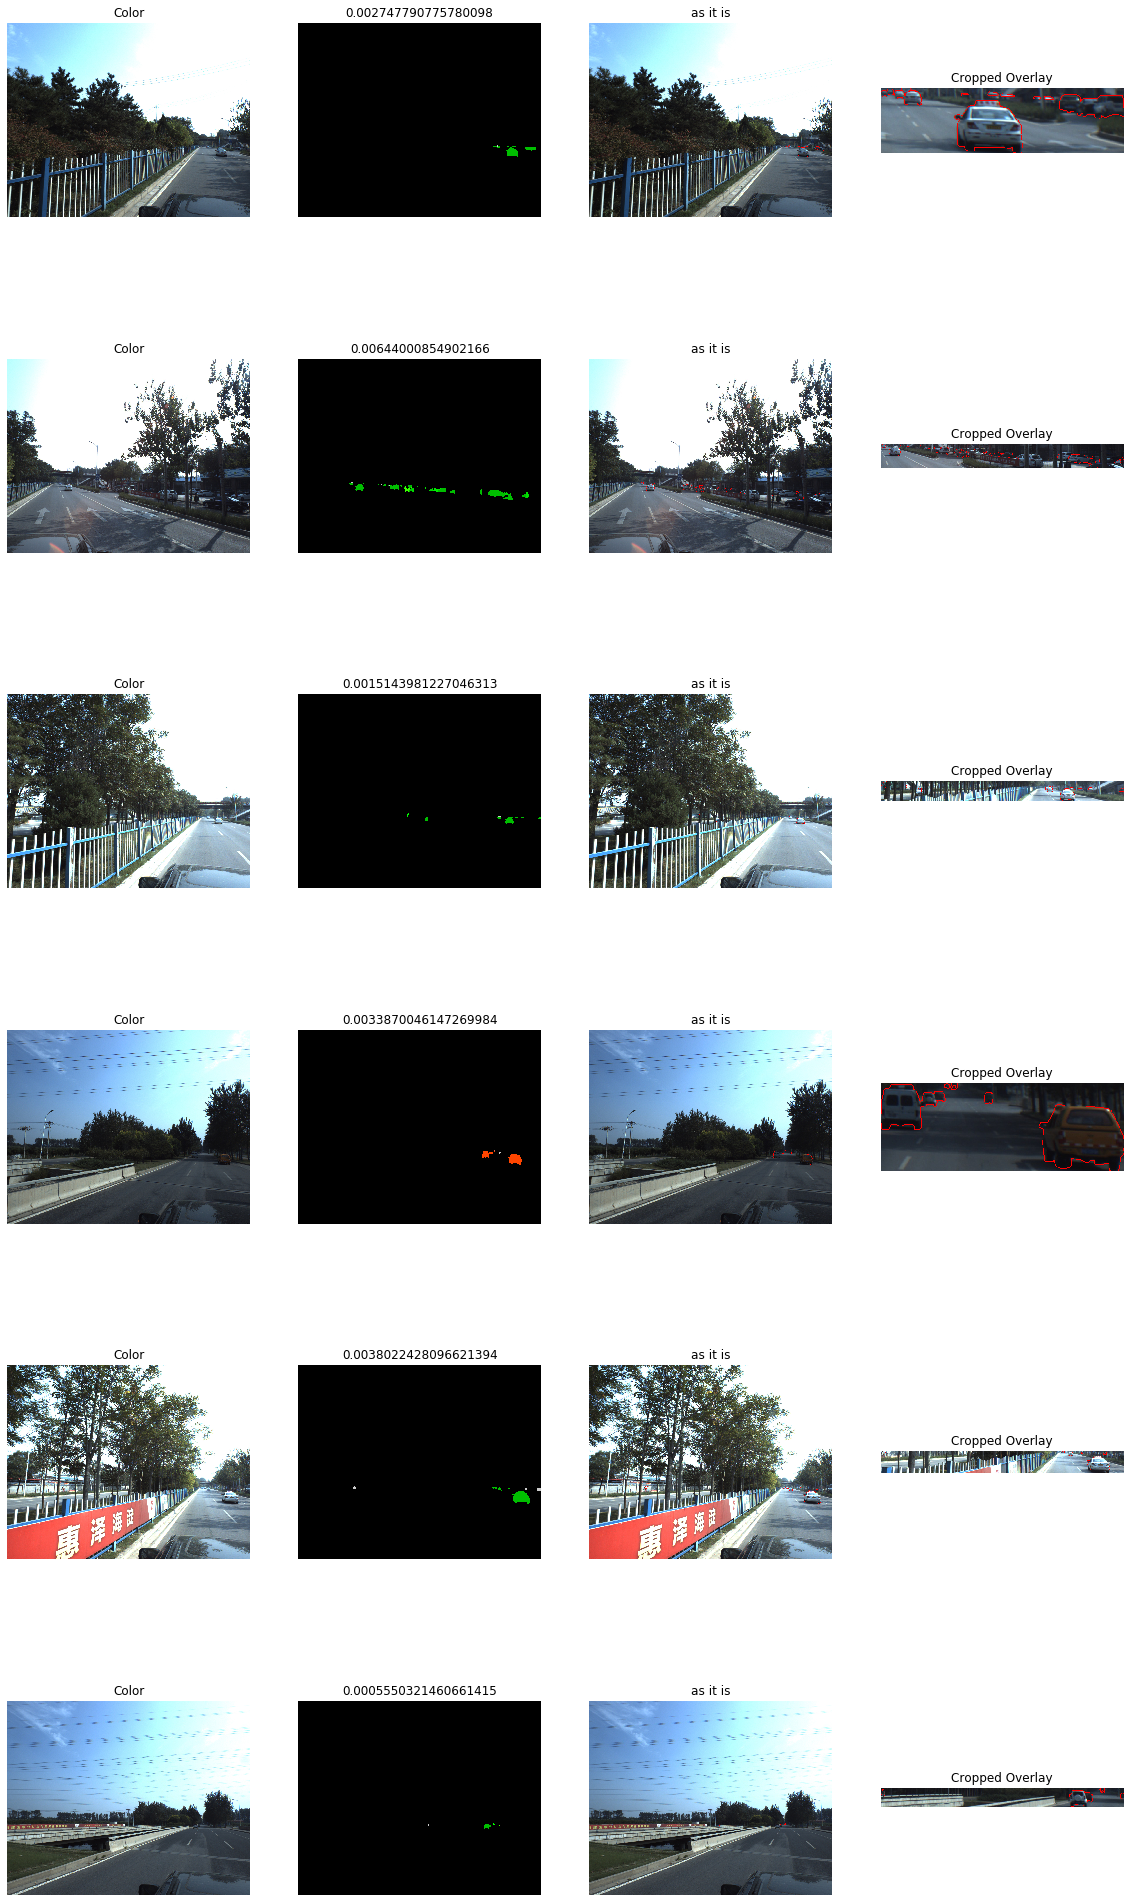

In [0]:
train_df = group_df.query('split=="train"')
print(train_df.shape[0], 'rows')
sample_rows = 6
fig,m_axs = plt.subplots(sample_rows,4,figsize = (20,6*sample_rows))

# disabling axis labels
[c_ax.axis('off') for c_ax in m_axs.flatten()]

out_rows = []
for (ax1, ax2, ax3, ax4), (_, c_row) in zip(m_axs, train_df.sample(sample_rows).iterrows()):
  
    #     ax* : subplots obj reference
    #     _ : row id
    #     c_row: row values
    
    c_img = imread(c_row['color'])
    l_img = imread(c_row['label'])//1000
    ax1.imshow(c_img)
    ax1.set_title('Color')
    ax2.imshow(l_img, cmap = 'nipy_spectral')
    
    # Picks the labels and % coverage for car column and sets that % as title for Label image
    ax2.set_title('{car}'.format(**get_label_info(c_row['label'])))
    
    # finds the matrix positions(pixel locations) where label values are greater tha zero for x and y respectively
    xd, yd = np.where(l_img>0)
    
    # Mark_boundaries function takes an image and its label image(with label values) and creates boundary
    bound_img = mark_boundaries(image = c_img, label_img = l_img, color = (1,0,0), background_label = 255, mode = 'thick')
    
    ax3.imshow(bound_img)
    ax3.set_title('as it is')
    
    # Below takes the starting position(top left) and end position(bottom right) in the label image and displays only the subset of image
    ax4.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
    ax4.set_title('Cropped Overlay')
    
    # generates the composition % for each of the focus group label and will be used to generate a dataframe
    out_rows += [get_label_info(c_row['label'])]


In [0]:
pd.DataFrame(out_rows)

dim       car  motorbicycle  ...  overpass  vegatation  unlabeled
0  (2710, 3384)  0.002748           0.0  ...       0.0         0.0        0.0
1  (2710, 3384)  0.006440           0.0  ...       0.0         0.0        0.0
2  (2710, 3384)  0.001514           0.0  ...       0.0         0.0        0.0
3  (2710, 3384)  0.003387           0.0  ...       0.0         0.0        0.0
4  (2710, 3384)  0.003802           0.0  ...       0.0         0.0        0.0
5  (2710, 3384)  0.000555           0.0  ...       0.0         0.0        0.0

[6 rows x 37 columns]

Let's assess how much time it takes to get the % composition of each label in its respective image

In [0]:
# Function takes a row in a df as input and returns % composition
def read_row(in_row):
    return dict(**in_row, **get_label_info(in_row['label']))

In [0]:
%%time
all_rows = []
for _, c_row in list(train_df.sample(40).iterrows()):
    all_rows += [read_row(c_row.to_dict())]

CPU times: user 16.2 s, sys: 256 ms, total: 16.5 s
Wall time: 32.9 s


Dask let's us speed up the processes substantially by utilizing multiple cores

In [0]:
%%time
from dask import bag
some_rows = bag.from_sequence([x.to_dict() for _, x in train_df.sample(40).iterrows()]).map(read_row)
_ = some_rows.compute()

CPU times: user 258 ms, sys: 64.2 ms, total: 322 ms
Wall time: 19.3 s


Lets do it for all rows

In [0]:
all_rows = bag.from_sequence([x.to_dict() for _, x in train_df.iterrows()], npartitions = 10000).map(read_row)

In [0]:
%%time
all_rows_df = pd.DataFrame(all_rows.compute())

CPU times: user 6.2 s, sys: 331 ms, total: 6.54 s
Wall time: 7min 22s


In [0]:
ordered_cols = list(train_df.columns)+['dim']
for c_col in all_rows_df.columns:
    if c_col not in ordered_cols:
        ordered_cols += [c_col]
all_rows_df = all_rows_df[ordered_cols]
all_rows_df.to_csv('label_breakdown.csv')
all_rows_df.sample(5)

id  split  ... vegatation unlabeled
649  170908_062211688_Camera_6  train  ...        0.0       0.0
960  170908_062233995_Camera_5  train  ...        0.0       0.0
408  170908_061530763_Camera_5  train  ...        0.0       0.0
292  170908_061522702_Camera_5  train  ...        0.0       0.0
814  170908_062223557_Camera_5  train  ...        0.0       0.0

[5 rows x 41 columns]

In [0]:
all_rows_df.to_csv('label_breakdown.csv',header=True,index=False, encoding='utf-8')

Now the Label breakdown is ready, lets work on the Segmentation

In [0]:
# Function to retain only the focus group ids in the Labels image as 1s and the rest to 0s 
def read_label_image(in_path):
  idx_image = imread(in_path)//1000
  return np.isin(idx_image.ravel(),car_idx).reshape(idx_image.shape).astype(np.float32)

In [0]:
group_df  = all_rows_df

In [0]:
group_df.sample(3)

id  split  ... unlabeled total_vehicle
581  170908_062206227_Camera_6  train  ...       0.0      0.052752
828  170908_062224558_Camera_5  train  ...       0.0      0.002881
997  170908_062236569_Camera_6  train  ...       0.0      0.068392

[3 rows x 42 columns]

Below Function sums up all the % Compositions of labels in a image, this can be used to indentify the images with more no. of labels

In [0]:
def total_car_vol(in_row):
    out_val = 0.0
    for k in car_classes:
        out_val += in_row[k]
    return out_val
    

Below code helps us to get the Images which have more no. of Focus group vehicles. Let's take the top 100 images.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


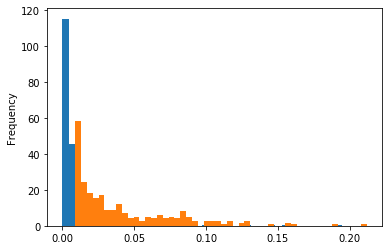

In [0]:
group_df['total_vehicle'] = group_df.apply(total_car_vol,1)
group_df['total_vehicle'].plot.hist(bins = 50, normed = True)
train_df = group_df.sort_values('total_vehicle', ascending = False).head(300)
train_df['total_vehicle'].plot.hist(bins = 50, normed = True)

# Blue bars represents all 1000 Images, most of the images in there have very less labels present in them
# Orange bars are images which have more labels, notice they start from value arounnd 0.04 rather than 0(means negligible presence of labels)

In [0]:
train_df.head()

id  split  ... unlabeled total_vehicle
282  170908_061522007_Camera_5  train  ...       0.0      0.212012
284  170908_061522146_Camera_5  train  ...       0.0      0.190927
595  170908_062207602_Camera_6  train  ...       0.0      0.160417
280  170908_061521868_Camera_5  train  ...       0.0      0.158996
597  170908_062207787_Camera_6  train  ...       0.0      0.155266

[5 rows x 42 columns]

In [0]:
# <Don><End>

**Mask-RCNN Starter Model for the Airbus Ship Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

We get some amazing performance training only within the 6hrs kaggle kernel limit.

Now we have the Images which have more classes, Let's use them to build our model

In [0]:
debug = True

In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
DATA_DIR = '/content/drive/My Drive/Capstone/'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 48.98 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
# Import Mask RCNN
sys.path.append(os.path.join('.', 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
train_dicom_dir = os.path.join(DATA_DIR, 'train_color')
test_dicom_dir = os.path.join(DATA_DIR, 'test')

### Download COCO pre-trained weights

In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'CVPR Image Instance Segmentation'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 36  # background and Vehicle classes
    
    # To be explored
    # IMAGE_MIN_DIM = 384
    # IMAGE_MAX_DIM = 384

    # to be changed, check the image shape outcome
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384

    RPN_ANCHOR_SCALES = (8, 16, 32, 64)

    TRAIN_ROIS_PER_IMAGE = 64

    # Maximum Ground Truth Instances
    # MAX_GT_INSTANCES = 14
    MAX_GT_INSTANCES = 40

    # DETECTION_MAX_INSTANCES = 10
    DETECTION_MAX_INSTANCES = 30

    # DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_MIN_CONFIDENCE = 0.6

    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    # Look for the significance
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                48
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE              

Lets create Encode and Decode mapping functions

In [0]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(2710, 3384)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((2710, 3384), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((2710, 3384), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [0]:
from PIL import Image
from sklearn.model_selection import train_test_split

# exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
#                 '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
#                 'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
#                 'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir)]
test_names = [f for f in os.listdir(test_dicom_dir) ]

print(len(train_names), len(test_names))

1000 500


In [0]:
label_dir = '/content/drive/My Drive/Capstone/train_label/'
filelist = os.listdir(label_dir)

In [0]:
train_label_name  = train_df['id'] + '_instanceIds.png'

In [0]:
final_fileslist = [ m for m in  filelist if m in train_label_name.to_list()]

In [0]:
len(final_fileslist)

**Enable below commented code if you need to generate your own RLE, otherwise skip it**

In [0]:

# rle_input_labels = pd.DataFrame(columns=['Image_ID','RLE','Class_ID','Instance_ID'])

# count= 0
# row =0 
# for j in tqdm(final_fileslist):
#     #im = Image.open(label_dir + j)


#     #tlabel1 = np.asarray(Image.open(label_dir + j))//1000

#     # Highlighting label's pixels
#     #tlabel1[tlabel1!= 0] = 255

#     #plt.imshow(Image.blend(im, Image.fromarray(tlabel1).convert('RGB'), alpha=0.6))
#     #display(plt.show())
    
#     photo = Image.open(label_dir + j)
#     #photo = Image.open("/content/drive/My Drive/Capstone/train_label/170908_061502547_Camera_5_instanceIds.png")
#     #print(j)
    
#     pic = img_to_array(photo)
#     #print(pic.shape)
#     flat_img = pic.flatten()
#     img_index = len(flat_img)
#     unique_Values = np.unique(flat_img)
#     unique_Values = unique_Values[unique_Values!=255]
#     #print(img_index)
    
#     for i in unique_Values:
      
#       counter = 0
#       counter1 = 0
#       count1 = 0
#       position_array = []
#       counter_array = []
#       final_array = []
#       final_string = ''

#       for k in range(img_index):
        
#         if (flat_img[k] == i ):
#           counter+=1
#           if (counter==1):
#             position = k
#             #position_array = position_array.append(position)
#         else:
#           counter1 = counter
#           counter = 0
        
#         if(counter1 != 0):
#           position_array.append(position)
#           counter_array.append(counter1)
#           #print(position, counter1)
#         #counter = 0
        

#       # print(int(i))#, len(position_array), len(counter_array))
#       #print('Position_array: ', position_array)
#       #print('Counter_array: ', counter_array)
#       #print('\n')

#       for z in range(len(position_array)):
#         final_array.append(position_array[z])
#         final_string =final_string+' '+str(position_array[z])
#         final_array.append(counter_array[z])
#         final_string=final_string+' '+str(counter_array[z])
       
#       rec = [j,final_string,int(i),int(i%1000)]
#       rle_input_labels.loc[row] = rec
#       row+=1
#       #print('Spreadsheet_entry: ',final_array)
#       #print('String entry: ', final_string)
#       #print('\n')
      

# rle_input_labels.to_csv('train_ship_segmentations_v2.csv',index=False)

100%|██████████| 300/300 [5:39:56<00:00, 95.65s/it]


In [0]:
# Importing RLE
SEGMENTATION = '/content/Mask_RCNN/train_ship_segmentations_v2.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

Image_ID  ... Instance_ID
0  170908_061506439_Camera_5_instanceIds.png  ...           0
1  170908_061506439_Camera_5_instanceIds.png  ...           1
2  170908_061506439_Camera_5_instanceIds.png  ...           2
3  170908_061506439_Camera_5_instanceIds.png  ...           3
4  170908_061506439_Camera_5_instanceIds.png  ...           4

[5 rows x 4 columns]

In [0]:
anns = anns[anns.Class_ID.notnull()]

In [0]:
anns['Class'] = (anns['Class_ID']//1000).astype(str)

In [0]:
anns.head()

Image_ID  ... Class
0  170908_061506439_Camera_5_instanceIds.png  ...    33
1  170908_061506439_Camera_5_instanceIds.png  ...    33
2  170908_061506439_Camera_5_instanceIds.png  ...    33
3  170908_061506439_Camera_5_instanceIds.png  ...    33
4  170908_061506439_Camera_5_instanceIds.png  ...    33

[5 rows x 5 columns]

In [0]:
#train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships
train_names = anns[anns.RLE.notnull()].Image_ID.unique().tolist()  ## override with ships

test_size = 100 #config.VALIDATION_STEPS * config.IMAGES_PER_GPU
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

if debug:
    image_fps_train = image_fps_train[:200]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    
print(len(image_fps_train), len(image_fps_val), len(test_names))

200 100 100


In [0]:
image_fps, image_annotations = train_names, anns

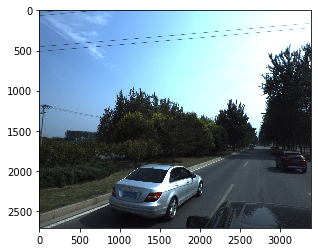

In [0]:
ds = imread(os.path.join(train_dicom_dir, image_fps[90][0:25] + '.jpg')) # read  image from filepath 
_ = plt.imshow(ds)

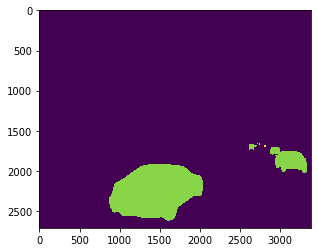

In [0]:
ds1 = imread('/content/drive/My Drive/Capstone/train_label/'+ image_fps[90]) # read  image from filepath 
_ = plt.imshow(ds1)

In [0]:
classdict = {0:'others', 1:'rover', 17:'sky', 33:'car', 34:'motorbicycle', 35:'bicycle', 36:'person', 37:'rider', 38:'truck', 39:'bus', 40:'tricycle', 49:'road', 50:'siderwalk', 65:'traffic_cone'}
classdict_new = {9:'others', 10:'rover', 11:'sky', 1:'car', 2:'motorbicycle', 3:'bicycle', 4:'person', 5:'rider', 6:'truck', 7:'bus', 8:'tricycle', 20:'road', 21:'siderwalk', 22:'traffic_cone'}
classdict_map = {9:0, 10:1, 11:17, 1:33, 2:34, 3:35, 4:36, 5:37, 6:38, 7:39, 8:40, 20:49, 21:50, 22:65}
# classdictrev_map = {0:9, 1:10,17:11, 33:1, 34:2, 35:3, 36:4, 37:5, 38:6, 39:7, 40:8, 49:20, 50:21, 65:22}
classdictrev_map = {value:key for key, value in classdict_map.items()} 

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """
  
    valuedict = {value:key for key, value in classdict_new.items()} 

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        
        self.add_class('CVPR',1,'car')
        self.add_class('CVPR',2,'motorbicycle')
        self.add_class('CVPR',3,'bicycle')
        self.add_class('CVPR',4,'person')
        self.add_class('CVPR',5,'rider')
        self.add_class('CVPR',6,'truck')
        self.add_class('CVPR',7,'bus')
        self.add_class('CVPR',8,'tricycle')
        self.add_class('CVPR',9,'others')
        self.add_class('CVPR',10,'rover')
        self.add_class('CVPR',11,'sky')
        self.add_class('CVPR',12,'car_Groups')
        self.add_class('CVPR',13,'motorbicycle_Group')
        self.add_class('CVPR',14,'bicycle_Group')
        self.add_class('CVPR',15,'person_Group')
        self.add_class('CVPR',16,'rider_Group')
        self.add_class('CVPR',17,'truck_Group')
        self.add_class('CVPR',18,'bus_Group')
        self.add_class('CVPR',19,'tricycle_Group')
        self.add_class('CVPR',20,'road')
        self.add_class('CVPR',21,'siderwalk')
        self.add_class('CVPR',22,'traffic_Cone')
        self.add_class('CVPR',23,'road_Pile')
        self.add_class('CVPR',24,'fence')
        self.add_class('CVPR',25,'traffic_Light')
        self.add_class('CVPR',26,'pole')
        self.add_class('CVPR',27,'traffic_Sign')
        self.add_class('CVPR',28,'wall')
        self.add_class('CVPR',29,'dustbin')
        self.add_class('CVPR',30,'billboard')
        self.add_class('CVPR',31,'building')
        self.add_class('CVPR',32,'bridge')
        self.add_class('CVPR',33,'tunnel')
        self.add_class('CVPR',34,'overpass')
        self.add_class('CVPR',35,'vegatation')



        # add images 
        
        for i,fp in enumerate(image_fps):
            
              class_id = image_annotations.query('Image_ID=="' + fp + '"')['Class']
              annotations = image_annotations.query('Image_ID=="' + fp + '"')['RLE']
              
              class_id = class_id.astype(int)
              classes = []

              for j in class_id:
                classes.append(classdictrev_map[j])


              self.add_image('CVPR', image_id=i, path=os.path.join(train_dicom_dir, fp[0:25] + '.jpg'), 
                                      annotations=annotations,class_list = classes, orig_height=orig_height, orig_width=orig_width)


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):

        info = self.image_info[image_id]
        annotations = info['annotations']
        class_name = info['class_list']
        

        count = len(annotations)
        
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
            
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            
            i = 0
            for a,c in zip(annotations,class_name):
                mask[:, :, i] = rle_decode(a)
                
                class_ids[i] = c
                
                i+=1
            
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Create and prepare the training dataset using the DetectorDataset class.

In [0]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, 2710, 3384)
dataset_train.prepare()

CPU times: user 693 ms, sys: 7.89 ms, total: 701 ms
Wall time: 703 ms


In [0]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, 2710, 3384)
dataset_val.prepare()

CPU times: user 358 ms, sys: 7.95 ms, total: 366 ms
Wall time: 368 ms


### Display a random image with bounding boxes

23
/content/drive/My Drive/Capstone/train_color/170908_062219982_Camera_6.jpg


(-0.5, 3383.5, 2709.5, -0.5)

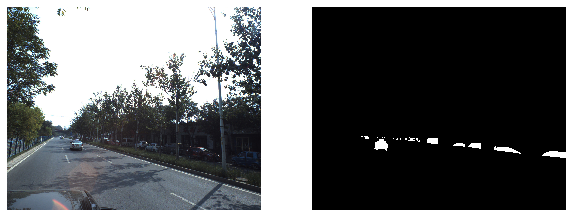

In [0]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    #image_id = 217
    print(image_id)
    image_fp = dataset_val.image_reference(image_id)
    print(image_fp)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])

for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]

plt.imshow(masked, cmap='gray')
plt.axis('off')


### Image Augmentation. Try finetuning some variables to custom values

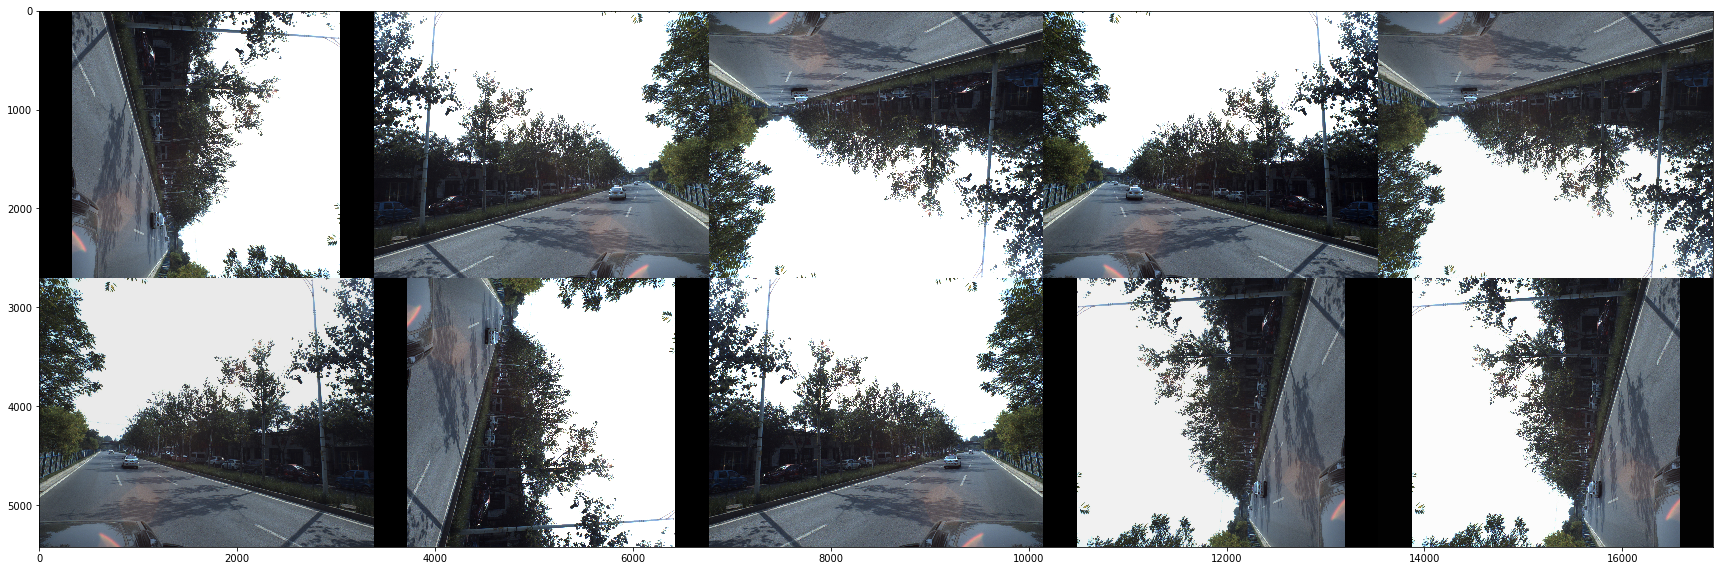

In [0]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='.')

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
LEARNING_RATE = 0.003
# LEARNING_RATE = 0.0000003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [0]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./cvpr image instance segmentation20191215T0745/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=4 if debug else 14,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.003

Checkpoint Path: ./cvpr image instance segmentation20191213T0455/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=6 if debug else 22,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.0015

Checkpoint Path: ./cvpr image instance segmentation20191213T0627/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

In [0]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1   8.431841            3.519540  ...         0.848174         0.870055
2   5.556411            2.319745  ...         0.606883         0.643791
3   9.155695            4.825883  ...         0.890501         0.906769
4   7.578070            3.953314  ...         0.791762         0.747399
5   6.383708            2.996309  ...         0.624926         0.649816
6   6.206995            2.631921  ...         0.523049         0.530797
7   9.866604            5.493044  ...         0.887550         1.041899
8   7.762614            3.541713  ...         0.845480         0.934568
9   6.005672            2.543232  ...         0.702376         0.851984
10  5.598338            2.111465  ...         0.661836         0.804203
11  5.485491            2.020650  ...         0.581448         0.760886
12  6.386722            2.615122  ...         0.529079         0.690243

[12 rows x 12 columns]

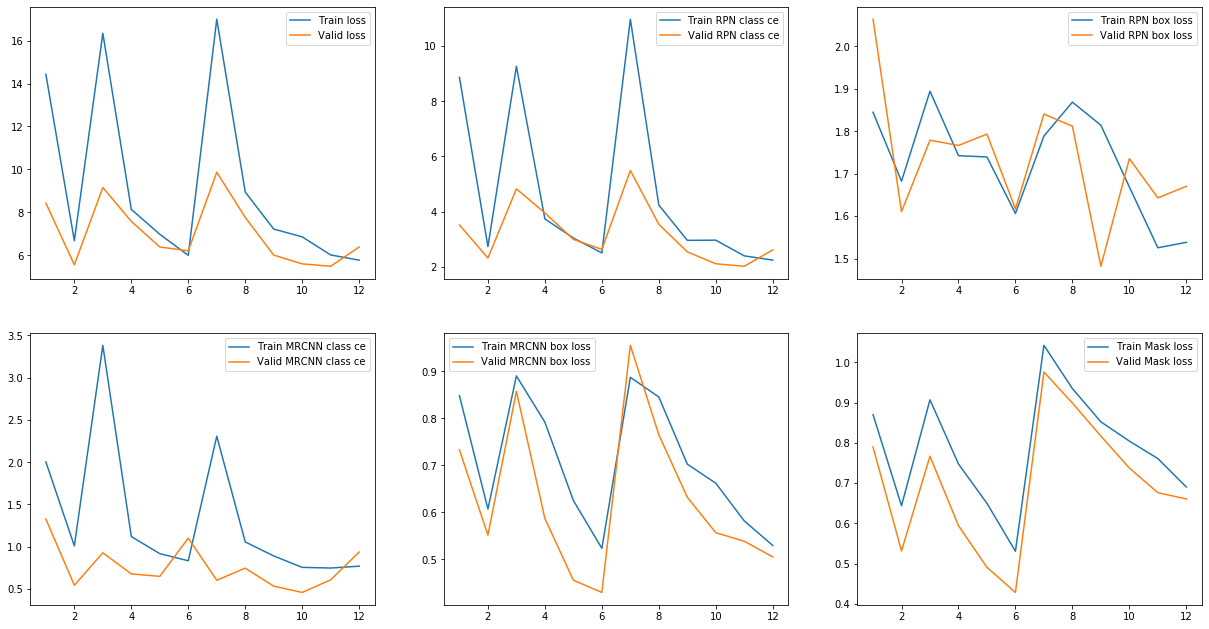

In [0]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [0]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:11 val_loss:5.485490560531616


In [0]:
# Pick the model with best val_acc
model_path = '/content/Mask_RCNN/cvpr image instance segmentation20191215T0745/mask_rcnn_cvpr image instance segmentation_0002.h5'

In [0]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='.')

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/cvpr image instance segmentation20191215T0745/mask_rcnn_cvpr image instance segmentation_0002.h5


In [0]:

# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:

        colors.append((round(random.random(),3), round(random.random(),3), round(random.random(),3)))
        
    return colors

In [0]:
(round(random.random(),3), round(random.random(),3), round(random.random(),3))

(0.91, 0.866, 0.207)

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

mAP :  0.05714285746216774
mAP :  0.1111111119389534
mAP :  0.05747126415371895

*** No instances to display *** 

mAP :  0.0
mAP :  0.1111111119389534
mAP :  0.04444444676240285
mAP :  0.0
mAP :  0.0833333358168602


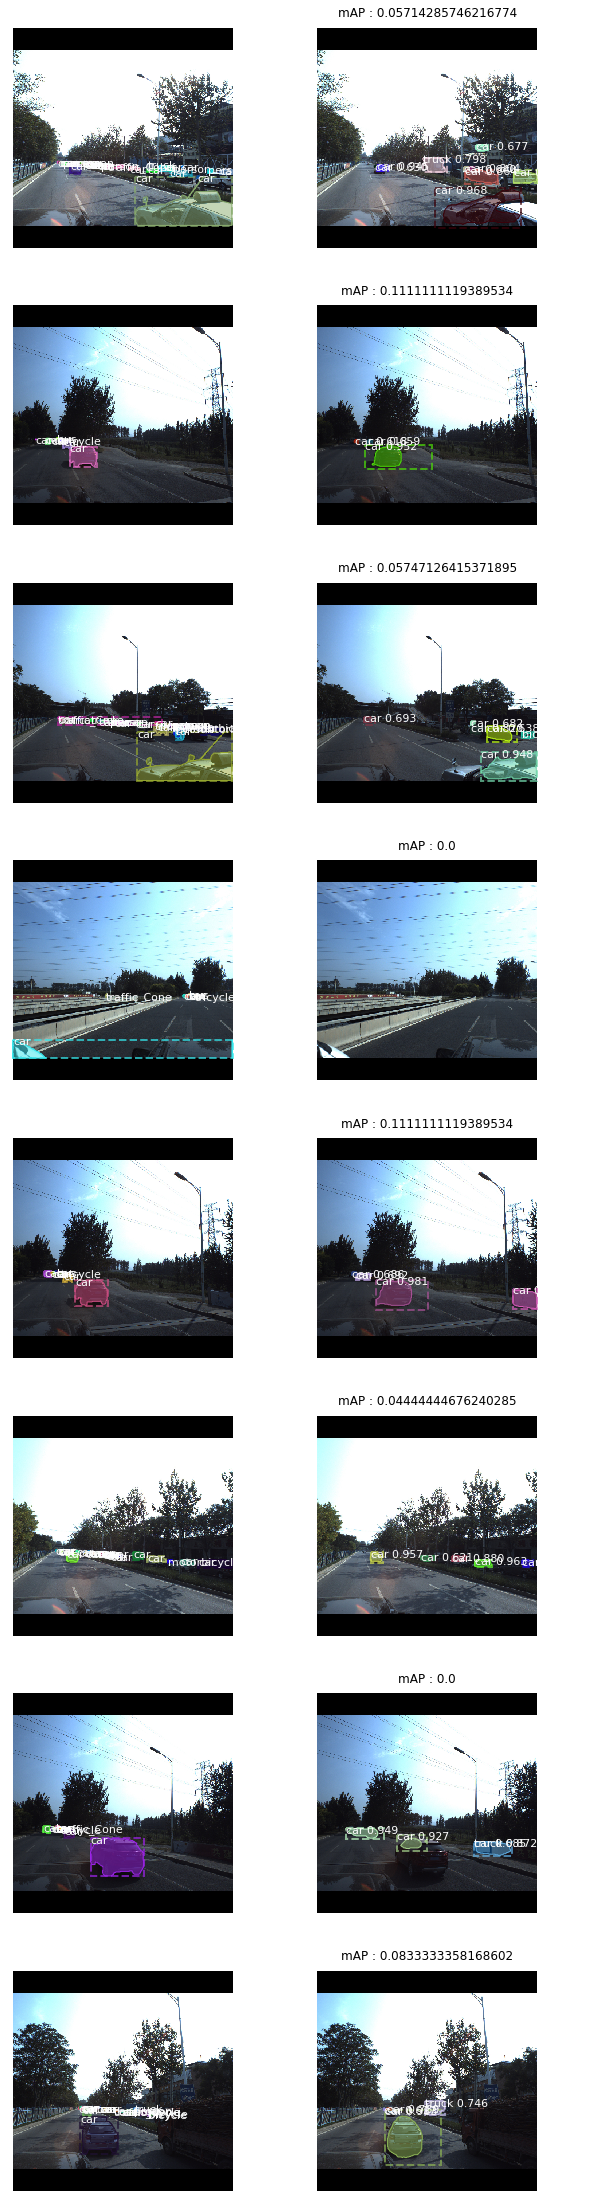

In [0]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    
    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'],
               iou_threshold=0.5)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1], title = "mAP : " + str(mAP))
    

    

In [0]:
import numpy as np

In [0]:

dataset = dataset_val
fig = plt.figure(figsize=(10, 40))
AvgmAP = []
for i in range(100):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    

    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    

    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
               r['rois'], r['class_ids'], r['scores'], r['masks'],
               iou_threshold=0.5)
    AvgmAP.append(mAP)

    
print("Average mAP : ", np.average(AvgmAP)  )

Average mAP :  0.1220226500362069


<Figure size 720x2880 with 0 Axes>

Model Evaluation

In [0]:
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        #AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls


In [0]:
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()